In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import datetime
import seaborn as sns
import numpy as np
sns.set(style='ticks')

from osgeo import gdal 
from scipy import stats
import affine
from tqdm import tqdm
gdal.UseExceptions()

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

n43w073 = gdal.Open(f'TIFs/0.tif')
n43w074 = gdal.Open(f'TIFs/1.tif')
n44w073 = gdal.Open(f'TIFs/2.tif')
n44w074 = gdal.Open(f'TIFs/3.tif')
n45w072 = gdal.Open(f'TIFs/4.tif')
n45w073 = gdal.Open(f'TIFs/5.tif')
n45w074 = gdal.Open(f'TIFs/6.tif')

ds0rb = np.array(n43w073.GetRasterBand(1).ReadAsArray().transpose())
ds1rb = np.array(n43w074.GetRasterBand(1).ReadAsArray().transpose())
ds2rb = np.array(n44w073.GetRasterBand(1).ReadAsArray().transpose())
ds3rb = np.array(n44w074.GetRasterBand(1).ReadAsArray().transpose())
ds4rb = np.array(n45w072.GetRasterBand(1).ReadAsArray().transpose())
ds5rb = np.array(n45w073.GetRasterBand(1).ReadAsArray().transpose())
ds6rb = np.array(n45w074.GetRasterBand(1).ReadAsArray().transpose())

In [624]:
def loadwater(filename,measure=[]):
    # loading csv
    print('Loading water sample data.')
    df = pd.read_csv(f'data/{filename}')
    clear_output()

    # cleaning water data
    df['ResultMeasureValue'] = pd.to_numeric(df['ResultMeasureValue'], errors='coerce')
    df['ActivityStartDate'] = pd.to_datetime(df['ActivityStartDate'])
    df['LastUpdated'] = pd.to_datetime(df['LastUpdated'])
    df['Year'] = df['LastUpdated'].dt.year
    df = df[~df['ResultMeasureValue'].isnull()]
    df['ResultMeasureValue'] = [i * 1000 if j=='mg/L' or j=='mg/K' else i for i,j in zip(df['ResultMeasureValue'],df['ResultMeasure/MeasureUnitCode'])]
    df = df[(df['ActivityLocation/LatitudeMeasure']>=42.74) & (df['ActivityLocation/LatitudeMeasure']<=45.00) & (df['ActivityLocation/LongitudeMeasure']>=-73.43) & (df['ActivityLocation/LongitudeMeasure']<=-71.48)]

    if len(measure)==1:
        df = df[df['CharacteristicName']==measure[0].capitalize()]
    if len(measure)==2:
        df = df[(df['CharacteristicName']==measure[0].capitalize()) | (df['CharacteristicName']==measure[1].capitalize())]

    return df


def getcoords(addresses):
    import requests
    import urllib.parse

    lats = []
    longs = []
    cnt = 0

    # looping over each entry in parcel data
    for i in tqdm(addresses):

        # using Nominatim to get coordinates, skipping if the request returns null
        try:
            url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(i) +'?format=json'
            response = requests.get(url).json()
            lats.append(response[0]["lat"])
            longs.append(response[0]["lon"])
        except IndexError:
            lats.append(np.nan)
            longs.append(np.nan)
        cnt += 1
        
    return lats, longs


def get_df_name(df):
    name =[x for x in locals() if locals()[x] is df][0]
    return name


def getpixelvalue(geo_coord, data_source, rb):
    """Return floating-point value that corresponds to given point."""
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)
    pixel_coord = px, py
    
    return rb[pixel_coord[0]][pixel_coord[1]]


def getelevation(lat,long):
    if 42<=lat<=43 and -73<=long<=-72:
        ds = n43w073 
        rb = ds0rb
    elif 42<=lat<=43 and -74<=long<=-73:
        ds = n43w074
        rb = ds1rb  
    elif 43<=lat<=44 and -73<=long<=-72:
        ds = n44w073
        rb = ds2rb
    elif 43<=lat<=44 and -74<=long<=-73:
        ds = n44w074
        rb = ds3rb
    elif 44<=lat<=45 and -72<=long<=-71:
        ds = n45w072
        rb = ds4rb
    elif 44<=lat<=45 and -73<=long<=-72:
        ds = n45w073
        rb = ds5rb
    elif 44<=lat<=45 and -74<=long<=-73:
        ds = n45w074
        rb = ds6rb
    else:
        print(lat,long)
    return getpixelvalue((long,lat),ds,rb)


def getelevations(df):
    print('Getting elevations.')
    elevations = []
    for lat,long in zip(df['Latitude'],df['Longitude']):
            elevations.append(getelevation(lat,long))
    df['Elevation'] = elevations
    return df


def addcoords(df):
    df = df[df['STGL']=='VT']
    print(f'Getting coordinates.')
    addresses= [f"{x['E911ADDR']}, {x['CITYGL']}, {x['STGL']}, {x['ZIPGL']}, United States" for x in df.to_dict('r')]
    lats,longs = getcoords(addresses)
    df['Latitude'] = pd.to_numeric(np.array(lats), errors='coerce')
    df['Longitude'] = pd.to_numeric(np.array(longs), errors='coerce')
    df.dropna(subset=['Latitude','Longitude'],inplace=True)
    df = df[(df['Latitude']>=42.74) & (df['Latitude']<=45.00) & (df['Longitude']>=-73.43) & (df['Longitude']<=-71.48)]

    df = getelevations(df)

    df.to_csv(f'data/{get_df_name(df)}.csv',index=False)
    clear_output()

    return df


def loadparcel(rewrite=[]):
    if len(rewrite)>0 and 'farm' in rewrite or 'indus' in rewrite:
        print('Loading parcel data.')
        df = pd.read_csv('data/parcel.csv',low_memory=False)
        df = df[df['STGL']=='VT']
        farm = df[df['CAT']=='Farm']
        indus = df[df['CAT']=='Industrial']
        indus = indus[(indus['DESCPROP'].str.contains('PLANT')) | (indus['DESCPROP'].str.contains('QUARRY')) | (indus['DESCPROP'].str.contains('PLT')) | (indus['DESCPROP'].str.contains('PLNT')) | (indus['DESCPROP'].str.contains('QUARRIES')) | (indus['DESCPROP'].str.contains('OMYA')) | (indus['DESCPROP'].str.contains('MILL')) | (indus['DESCPROP'].str.contains('GRAIN')) | (indus['DESCPROP'].str.contains('FILL')) | (indus['DESCPROP'].str.contains('MANU')) | (indus['DESCPROP'].str.contains('FACTORY'))]
        clear_output()

        if 'farm' in rewrite and len(rewrite)==1:
            farm = addcoords(farm)
            indus = pd.read_csv('data/indus.csv',low_memory=False)
        elif 'indus' in rewrite and len(rewrite)==1:
            farm = pd.read_csv('data/farm.csv',low_memory=False)
            indus = addcoords(indus)
        elif len(rewrite)>=2:
            farm = addcoords(farm)
            indus = addcoords(indus)
        clear_output()
        return farm, indus

    elif rewrite==['all']:
        print('Pulling full parcel data from saved CSV.')
        df = pd.read_csv('data/parcel.csv',low_memory=False)
        df = df[df['STGL']=='VT']
        clear_output()
        return df

    else:
        print('Pulling parcel data from saved CSVs.')
        farm = pd.read_csv('data/farm.csv',low_memory=False)
        farm = farm[farm['STGL']=='VT']
        indus = pd.read_csv('data/indus.csv',low_memory=False)
        indus = indus[indus['STGL']=='VT']
        indus = indus[(indus['DESCPROP'].str.contains('PLANT')) | (indus['DESCPROP'].str.contains('QUARRY')) | (indus['DESCPROP'].str.contains('PLT')) | (indus['DESCPROP'].str.contains('PLNT')) | (indus['DESCPROP'].str.contains('QUARRIES')) | (indus['DESCPROP'].str.contains('OMYA')) | (indus['DESCPROP'].str.contains('MILL')) | (indus['DESCPROP'].str.contains('GRAIN')) | (indus['DESCPROP'].str.contains('FILL')) | (indus['DESCPROP'].str.contains('MANU')) | (indus['DESCPROP'].str.contains('FACTORY'))]

        farm = farm[(farm['Latitude']>=42.74) & (farm['Latitude']<=45.00) & (farm['Longitude']>=-73.43) & (farm['Longitude']<=-71.48)]
        indus = indus[(indus['Latitude']>=42.74) & (indus['Latitude']<=45.00) & (indus['Longitude']>=-73.43) & (indus['Longitude']<=-71.48)]

        farm = getelevations(farm)
        indus = getelevations(indus)

        farm.to_csv('data/farm.csv',index=False)
        indus.to_csv('data/indus.csv',index=False)
        
        clear_output()
        return farm, indus


def alwayshigher(coordlist,waterlat,waterlong):
    verdictlist = []
    for i in coordlist:
        try:
            latvector = np.arange(i[0], waterlat, (waterlat-i[0])/10)
            longvector = np.arange(i[1],waterlong, (waterlong-i[1])/10)
            elevationvector = []

            for lat,long in zip(latvector,longvector):
                elevationvector.append(getelevation(lat,long))

            if np.array(elevationvector).max() > getelevation(i[0],i[1]):
                verdictlist.append(False)
            else:
                verdictlist.append(True)
        except ValueError:
            verdictlist.append(False)
    return verdictlist


def findnearest(water,allfarm,allindus):
    import geopy.distance as gd
    from tqdm import tqdm

    minyr = 2011 #np.array([farm['YEAR'].min(),indus['YEAR'].min()]).min()
    water = water[water['Year']>=minyr]

    totalfarms = []
    totalfarmarea = []
    nearestfarms = []
    nearestfarmid = []
    nearestfarmdistances = []

    totalindus = []
    totalindusarea = []
    nearestindus = []
    nearestindusid = []
    nearestindusdistances = []

    print('Finding nearest parcels to water samples.')
    time.sleep(.1)

    # looping over all water samples
    for w in tqdm(water.index):
        watercoords = (water.loc[w,'ActivityLocation/LatitudeMeasure'], water.loc[w,'ActivityLocation/LongitudeMeasure'])
        waterlat = water.loc[w,'ActivityLocation/LatitudeMeasure']
        waterlong = water.loc[w,'ActivityLocation/LongitudeMeasure']
        waterelev = water.loc[w,'Elevation']

        minfarmdist = np.inf
        minfarmname = ''
        minfarmid = ''

        minindusdist = np.inf
        minindusname = ''
        minindusid = ''

        farm = allfarm[(abs(allfarm['Latitude']-waterlat)<=.25) & (abs(allfarm['Longitude']-waterlong)<=.25) & (allfarm['Elevation']>waterelev)]
        farm['AlwaysHigher'] = alwayshigher(zip(farm['Latitude'],farm['Longitude']),waterlat,waterlong)
        farm = farm[farm['AlwaysHigher']==True]

        indus = allindus[(abs(allindus['Latitude']-waterlat)<=.5) & (abs(allindus['Longitude']-waterlong)<=.5) & (allindus['Elevation']>waterelev)]
        indus['AlwaysHigher'] = alwayshigher(zip(indus['Latitude'],indus['Longitude']),waterlat,waterlong)
        indus = indus[indus['AlwaysHigher']==True]

        # looping over farms using geopy to find distances 
        farmdists = []
        for f in farm.index:
            farmcoords = (farm.loc[f,'Latitude'], farm.loc[f,'Longitude'])
            farmdist = gd.geodesic(watercoords, farmcoords).miles
            farmname = ', '.join([farm.loc[f,'OWNER1'],farm.loc[f,'E911ADDR'],farm.loc[f,'TOWN']])
            farmid = farm.loc[f,'OBJECTID']
            farmdists.append(farmdist)

            if farmdist < minfarmdist:
                minfarmdist = farmdist
                minfarmname = farmname
                minfarmid = farmid

        totalfarms.append(farm.shape[0])
        totalfarmarea.append((np.array(farm['SHAPE_Area'])/np.array(farmdists)).sum())
        nearestfarms.append(minfarmname)
        nearestfarmid.append(minfarmid)
        nearestfarmdistances.append(minfarmdist)

        # looping over industries using geopy to find distances
        indusdists = [] 
        for i in indus.index:
            induscoords = (indus.loc[i,'Latitude'], indus.loc[i,'Longitude'])

            indusdist = gd.geodesic(watercoords, induscoords).miles
            indusname = ', '.join([indus.loc[i,'OWNER1'],indus.loc[i,'DESCPROP'],indus.loc[i,'E911ADDR'],indus.loc[i,'TOWN']])
            indusid = indus.loc[i,'OBJECTID']
            indusdists.append(indusdist)

            if indusdist < minindusdist:
                minindusdist = indusdist
                minindusname = indusname
                minindusid = indusid

        totalindus.append(indus.shape[0])
        totalindusarea.append((np.array(indus['SHAPE_Area'])/np.array(indusdists)).sum())
        nearestindus.append(minindusname)
        nearestindusid.append(minindusid)
        nearestindusdistances.append(minindusdist)

    water['TotalFarms'] = totalfarms
    water['TotalFarmArea'] = totalfarmarea
    water['NearestFarm'] = nearestfarms
    water['NearestFarmDist'] = nearestfarmdistances
    water['NearestFarmID'] = nearestfarmid

    water['TotalIndus'] = totalindus
    water['TotalIndusArea'] = totalindusarea
    water['NearestIndus'] = nearestindus
    water['NearestIndusDist'] = nearestindusdistances
    water['NearestIndusID'] = nearestindusid

    water['FarmLat'] = water['NearestFarmID'].map(dict(zip(allfarm['OBJECTID'],allfarm['Latitude'])))
    water['FarmLong'] = water['NearestFarmID'].map(dict(zip(allfarm['OBJECTID'],allfarm['Longitude'])))
    water['FarmElev'] = water['NearestFarmID'].map(dict(zip(allfarm['OBJECTID'],allfarm['Elevation'])))
    water['IndusLat'] = water['NearestIndusID'].map(dict(zip(allindus['OBJECTID'],allindus['Latitude'])))
    water['IndusLong'] = water['NearestIndusID'].map(dict(zip(allindus['OBJECTID'],allindus['Longitude'])))
    water['IndusElev'] = water['NearestIndusID'].map(dict(zip(allindus['OBJECTID'],allindus['Elevation'])))
    water['FarmElevDiff'] = water['FarmElev'] - water['Elevation']
    water['IndusElevDiff'] = water['IndusElev'] - water['Elevation']
    clear_output()
    return water


def get(measure,rewrite=[]):
    # loading water, farm, and industry data
    if len(rewrite)>0:
        water = loadwater('phosphorusandnitrogen.csv',[measure.capitalize()])
        farm,indus = loadparcel(rewrite)
        df = findnearest(water,farm,indus)
        seasons = {1:'Winter',2:'Spring',3:'Summer',4:'Fall'}
        df['Season'] = [i%12 // 3 + 1 for i in df['LastUpdated'].dt.month]
        df['SeasonName'] = df['Season'].map(seasons)
        df.to_csv(f'data/{measure}.csv',index=False)

    else:
        df = pd.read_csv(f'data/{measure}.csv',low_memory=False)
        farm,indus = loadparcel(rewrite)
        
    df = df[df['ResultSampleFractionText']=='Total']
    df['AdjMeasure'] = np.log10(df['ResultMeasureValue'])
    df = df[(np.abs(stats.zscore(df['AdjMeasure'])) < 2.5)]
    
    return df, farm, indus


def fit(df,feats,nestimators,maxdepth,displaycharts=False):
    crop = df.replace([np.inf], np.nan).dropna(subset=feats)

    scaler = StandardScaler().fit(crop[feats])
    X = scaler.transform(crop[feats])
    y = crop['AdjMeasure']

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

    reg = GradientBoostingRegressor(n_estimators=nestimators, learning_rate=.1, max_depth=maxdepth, random_state=0).fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    mae = round(mean_absolute_error(y_pred,y_test),3)
    rmse = round(np.sqrt(mean_squared_error(y_pred,y_test)),3)
    r2 = round(reg.score(X_test,y_test),3)

    if displaycharts:
        print(f'Coefficient of Determination: {r2}')
        print(f'Average Prediction Error: {mae}, {rmse}')
        plt.scatter(y_pred,y_test,color='#431C46',alpha=0.2)
        plt.plot(y_pred,y_pred,color='orange',linewidth=3)
        plt.ylim(y_test.min(),y_test.max())
        plt.xlim(y_test.min(),y_test.max())
        plt.show()    
        display(pd.DataFrame(zip(feats,reg.feature_importances_)))

    return reg,mae,feats,scaler,r2


def displayprediction(measure,unadj,bounds,df,location,season):

    actual = round(df[(df['MonitoringLocationName']==location) & (df['Season']==season)].sort_values('LastUpdated',ascending=False).reset_index()['ResultMeasureValue'][0],2)
    print(f'\nPredicted {measure.capitalize()}: {unadj} ug/L ...... {bounds} \nActual: {actual} ug/L')
    plt.figure(figsize=(7,0.3))
    ax = plt.axes()
    plt.scatter(df['ResultMeasureValue'],np.ones(df.shape[0]),color='orange',alpha=0.01,s=100)
    plt.axvspan(bounds[0],bounds[1], facecolor='#431C46',alpha=1)
    plt.scatter(unadj,1,color='white',s=500,marker='.',edgecolor='#431C46',linewidth=2,label='Predicted')
    plt.scatter(actual,1,color='white',s=500,marker='.',edgecolor='orange',linewidth=2,label='Actual')
    plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.yticks([])
    plt.xlabel(f'{measure.capitalize()} Concentration ug/L')
    plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.show()
    print(f"Min: {round(df['ResultMeasureValue'].min(),4)}, Max: {round(df['ResultMeasureValue'].max(),4)}, Mean: {round(df['ResultMeasureValue'].mean(),4)}")
    print('─' * 65)


def coordsfromsearch(query=''):
    if type(query)==str and (',' in query)==False:
        water = loadwater('phosphorusandnitrogen.csv')
        locationguess = water[water['MonitoringLocationName'].str.lower().str.contains(query.lower())]['MonitoringLocationName'].mode()[0]
        lat = float(water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).iloc[0,:]['ActivityLocation/LatitudeMeasure'])
        long = float(water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).iloc[0,:]['ActivityLocation/LongitudeMeasure'])
        otherlocations = list(water[water['MonitoringLocationName'].str.lower().str.contains(query.lower())]['MonitoringLocationName'].unique())[1:]
        nearestsample = (water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).reset_index()['ActivityLocation/LatitudeMeasure'][0], water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).reset_index()['ActivityLocation/LongitudeMeasure'][0])
        return lat,long,locationguess,otherlocations,nearestsample
    elif type(query)==str and (',' in query):
        lat,long = getcoords([query])
        lat,long = float(lat[0]), float(long[0])
        latstr = str(round(lat,2))
        longstr = str(round(long,2))
        locationguess = water[(water['ActivityLocation/LatitudeMeasure'].astype(str).str.contains(latstr)) & (water['ActivityLocation/LongitudeMeasure'].astype(str).str.contains(longstr))].sort_values('LastUpdated',ascending=False).reset_index()['MonitoringLocationName'][0]
        otherlocations = list(water[(water['ActivityLocation/LatitudeMeasure'].astype(str).str.contains(latstr)) & (water['ActivityLocation/LongitudeMeasure'].astype(str).str.contains(longstr))].sort_values('LastUpdated',ascending=False).reset_index()['MonitoringLocationName'].unique())[1:]
        nearestsample = (water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).reset_index()['ActivityLocation/LatitudeMeasure'][0], water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).reset_index()['ActivityLocation/LongitudeMeasure'][0])
        return lat,long,query,otherlocations,nearestsample
    elif type(query)==tuple:
        water = loadwater('phosphorusandnitrogen.csv')
        lat = query[0]
        long = query[1]
        latstr = str(round(lat,2))
        longstr = str(round(long,2))
        locationguess = water[(water['ActivityLocation/LatitudeMeasure'].astype(str).str.contains(latstr)) & (water['ActivityLocation/LongitudeMeasure'].astype(str).str.contains(longstr))].sort_values('LastUpdated',ascending=False).reset_index()['MonitoringLocationName'][0]
        otherlocations = list(water[(water['ActivityLocation/LatitudeMeasure'].astype(str).str.contains(latstr)) & (water['ActivityLocation/LongitudeMeasure'].astype(str).str.contains(longstr))].sort_values('LastUpdated',ascending=False).reset_index()['MonitoringLocationName'].unique())[1:]
        nearestsample = (water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).reset_index()['ActivityLocation/LatitudeMeasure'][0], water[water['MonitoringLocationName']==locationguess].sort_values('LastUpdated',ascending=False).reset_index()['ActivityLocation/LongitudeMeasure'][0])
        return lat,long,locationguess,otherlocations,nearestsample


def estimate(search='',displaycharts=False,displaymodel=False,rewrite=[],n_estimators=100,max_depth=1000):
    nitrogen = get('nitrogen',rewrite=rewrite)[0]
    phosphorus = get('phosphorus')[0]
    farm,indus = loadparcel()
    water = loadwater('phosphorusandnitrogen.csv')

    lat,long,location,otherlocations,nearestsample = coordsfromsearch(search)

    elevation = getelevation(lat,long)
    df = findnearest(pd.DataFrame({'ActivityLocation/LatitudeMeasure':lat,'ActivityLocation/LongitudeMeasure':long,'Year':datetime.date.today().year,'Elevation':elevation},index=[0]),farm,indus)
    df['Season'] = [i%12 // 3 + 1 for i in [datetime.date.today().month]]
    df['Year'] = [datetime.date.today().year]

    print(f'Results for "{search}":\n')
    print(f'Most Recent Water Sample: {location.title()}, {nearestsample}')
    print(f"Phosphorus: {round(phosphorus[phosphorus['MonitoringLocationName']==location].sort_values('LastUpdated',ascending=False).reset_index()['ResultMeasureValue'][0],2)}")
    print(f"Nitrogen: {round(nitrogen[nitrogen['MonitoringLocationName']==location].sort_values('LastUpdated',ascending=False).reset_index()['ResultMeasureValue'][0],2)}\n")
    print(f'Other Nearby Samples: {otherlocations}\n')
    print(f'Elevation: {"%.2f" % elevation} m ({"%.2f" % (3.28084*elevation)} ft)')
    print(f"Nearest Farm: {df['NearestFarm'][0].title()} ({round(df['NearestFarmDist'][0],2)} mi away and {round(df['FarmElevDiff'][0],2)} m up)")
    print(f"Nearest Industry: {df['NearestIndus'][0].title()} ({round(df['NearestIndusDist'][0],2)} mi away and {round(df['IndusElevDiff'][0],2)} m up)\n")
    print('─' * 65)

    if displaycharts:
        fig, ax = plt.subplots(figsize=(6,8))
        ax.imshow(plt.imread('images/vermont-rivers-map.jpg'), extent=[-73.43,-71.48, 42.74, 45.0],alpha=1)
        ax.imshow(plt.imread('images/vermont-state-map.jpg'), extent=[-73.43,-71.48, 42.74, 45.0],alpha=.6)
        ax.axvline(long,color='#1E1E1E',zorder=0)
        ax.axhline(lat,color='#1E1E1E',zorder=0)
        ax.scatter(water['ActivityLocation/LongitudeMeasure'],water['ActivityLocation/LatitudeMeasure'],color='white',s=1,alpha=0.2,label='Water Samples')
        ax.scatter(farm['Longitude'],farm['Latitude'],s=farm['SHAPE_Area']/20000,alpha=.6,label='Farms',color='#431C46')
        ax.scatter(indus['Longitude'],indus['Latitude'],s=indus['SHAPE_Area']/20000,alpha=.6,label='Industries',color='darkorange')
        ax.scatter(long,lat,s=7000,color='white',alpha=0.3)
        ax.scatter(df['FarmLong'],df['FarmLat'],s=100,color='#431C46',edgecolor='#431C46',linewidth=2)
        ax.scatter(df['IndusLong'],df['IndusLat'],s=100,color='orange',edgecolor='#431C46',linewidth=2)
        ax.scatter(long,lat,s=100,color='white',edgecolor='#431C46',linewidth=2)
        plt.legend(loc="center right")
        plt.show()
        print('─' * 65)

    try:
        print('Fitting regressors.')

        df = df.replace([np.inf,0], np.nan)
        allfeats = ['Season','FarmElevDiff','TotalFarmArea','NearestFarmDist','TotalFarms']#,'IndusElevDiff','NearestIndusDist', 'TotalIndus']
        feats = []
        for i in allfeats:
            if df[i][0]>0: feats.append(i)
            else: pass

        phos,phosmae,phosfeats,phoscaler,phoscore = fit(phosphorus,feats,n_estimators,max_depth,displaymodel)
        nit,nitmae,nitfeats,nitscaler,nitscore = fit(nitrogen,feats,n_estimators,max_depth,displaymodel)
        
        phosX = phoscaler.transform(df[phosfeats])
        nitX = nitscaler.transform(df[nitfeats])
    
        phospred = phos.predict(phosX)[0]
        phosunadj = round(10**phospred,3)
        phosbounds = (round(10**(phospred - phosmae),3), round(10**(phospred + phosmae),3))

        nitpred = nit.predict(nitX)[0]
        nitunadj = round(10**nitpred,3)
        nitbounds = (round(10**(nitpred - nitmae),3), round(10**(nitpred + nitmae),3))
        
        print('─' * 65)
        if displaycharts:
            displayprediction('phosphorus',phosunadj,phosbounds,phosphorus,location,df['Season'][0])
            displayprediction('nitrogen',nitunadj,nitbounds,nitrogen,location,df['Season'][0])
            print(f'\nFeatures used: {feats}')
            print(f'Values: {list(df[feats].iloc[0,:])}\n')
            print(f'Phosphorus Model Testing R2: {"%.2f" % (phoscore*100)}%, MAE: {round(phosmae,2)}')
            print(f'Nitrogen Model Testing R2: {"%.2f" % (nitscore*100)}%, MAE: {round(nitmae,2)}')

    except ValueError:
        print('Cannot predict. Most likely due to lack of nearby upstream polluters.')
        raise ValueError()
        
    
    del water,nitrogen,phosphorus,farm,indus

Results for "(44.5, -72)":

Most Recent Water Sample: Flagg Pond, (44.5653, -72.2072)
Phosphorus: 0.01
Nitrogen: 300.0

Other Nearby Samples: ['Caspian Lake', 'Stannard Pond', 'Cemetery Brook - Field Runoff', 'Tate Brook', 'Caspian Lake Trib 6', 'Caspian Lake Trib 1', 'Greensboro Brook', 'Caspian Lake Trib 10', 'Lake Elligo (Eligo Pond)', 'East Long Pond', 'Lake Elmore', 'Coles Pond', 'Big Spruce Brook', 'Millers Run', 'Ranch Brook', 'Bedell Brook', 'Little Spruce Brook', 'Lamoille River', 'Passumpsic River', 'Flagg Pond Sweet Gale Shoreline Swamp', 'Cemetery Brook', 'Chandler Pond', 'Wolcott Pond', 'West Branch Little River', 'Lake Lamoille', 'Ryder Brook', 'Browns River', 'Centerville Brook', 'Stannard Brook', 'Elmore Branch', 'Kate Brook', 'Bunker Brook', 'Stevensville Brook', 'Porter Brook', 'Tucker Brook', 'Rodman Brook', 'Mud Brook', 'Steam Mill Brook', 'The Creek', 'Kenfield Brook', 'Bear Swamp', 'Sterling Pond', 'Tuttle Pond', 'Wild Branch', 'Jacob Brook', 'Inn brook', 'Brewste

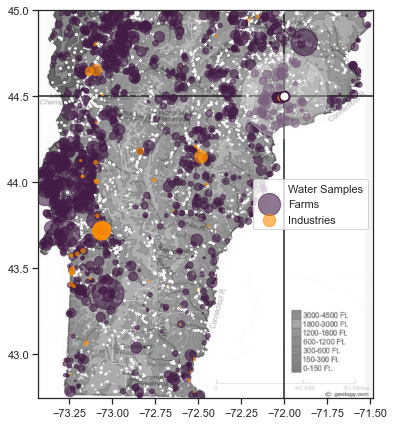

─────────────────────────────────────────────────────────────────
Fitting regressors.
─────────────────────────────────────────────────────────────────

Predicted Phosphorus: 0.096 ug/L ...... (0.065, 0.143) 
Actual: 0.01 ug/L


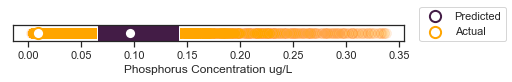

Min: 0.003, Max: 0.338, Mean: 0.0382
─────────────────────────────────────────────────────────────────

Predicted Nitrogen: 280.004 ug/L ...... (206.616, 379.458) 
Actual: 240.0 ug/L


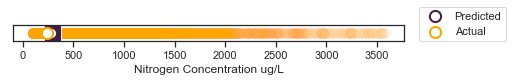

Min: 80.0, Max: 3590.0, Mean: 561.7151
─────────────────────────────────────────────────────────────────

Features used: ['Season', 'FarmElevDiff', 'TotalFarmArea', 'NearestFarmDist', 'TotalFarms']
Values: [2.0, 178.4662322998047, 1986831.29236997, 2.075937150593143, 16.0]

Phosphorus Model Testing R2: 64.00%, MAE: 0.17
Nitrogen Model Testing R2: 55.80%, MAE: 0.13


In [625]:
estimate((44.5,-72),displaycharts=True)